# This is just a quick and dirty notebook for getting things started

# Imports

In [1]:
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

/Users/jinli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Set Up 

In [2]:
# Paths
training_dataset_path = "art_images/dataset_updated/training_set"
test_dataset_path = "art_images/dataset_updated/validation_set"
corrupt_path = "art_images/dataset_updated/training_set_corrupted"

In [3]:
categories = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
n_categories = len(categories)

category_embeddings = {
    'drawings': 0,
    'engraving': 1,
    'iconography': 2,
    'painting': 3,
    'sculpture': 4
}

In [4]:
width = 128 # 368
height = 128 # 352
n_channels = 3

In [5]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Brief Visualization

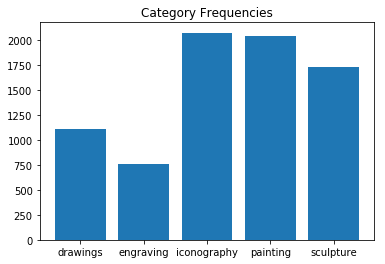

In [8]:
# visualize categorical distributions
def view_freq(categories, training_dataset_path):
    """
    Create a bar graph for visualizing categorical frequencies

    :param categories: list of categories
    :type  categories: list
    :param training_dataset_path: relative path of the training dataset
    :type  training_dataset_path: str
    """

    n_imgs = []
    for cat in categories:
        files = os.listdir(os.path.join(training_dataset_path, cat))
        n_imgs += [len(files)]

    plt.bar([_ for _ in range(len(categories))], n_imgs, tick_label=categories)
    plt.title("Category Frequencies")
    plt.show()


view_freq(categories, training_dataset_path)

/Users/jinli/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


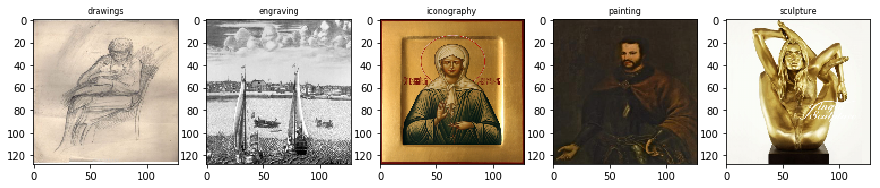

In [17]:
def view_images(categories, training_dataset_path):
    """
    View one image from each category

    :param categories: list of categories
    :type  categories: list
    :param training_dataset_path: relative path of the training dataset
    :type  training_dataset_path: str
    """
    
    n_categories = len (categories)
    fig, axes = plt.subplots(nrows=1, ncols=n_categories, figsize=(15, 3))

    cat_cpt=0
    for cat in categories:
        category_path = os.path.join(training_dataset_path, cat)
        img_name = os.listdir(category_path)[1]
        img = skimage.io.imread(os.path.join(category_path, img_name))
        img = skimage.transform.resize(img, (width, height, n_channels), mode='reflect')
        axes[cat_cpt].imshow(img, resample=True)
        axes[cat_cpt].set_title(cat, fontsize=8)
        cat_cpt += 1

    plt.show()
    
view_images(categories, training_dataset_path)

In [18]:
def get_file_names(categories, training_dataset_path, test_dataset_path):
    """
    Get all the file names and its category

    :param categories: list of categories
    :type  categories: list
    :param training_dataset_path: relative path of the training dataset
    :type  training_dataset_path: str
    :param test_dataset_path: relative path of the test dataset
    :type  test_dataset_path: str
    :returns: (list of tuples of train, where first element of tuple is file name,
               and second element is the category, list of tuples of test)
    :rtype:   (list, list)
    """

    training_data = []
    for cat in categories:
        files = os.listdir(os.path.join(training_dataset_path, cat))
        for file in files:
            training_data.append((os.path.join(cat, file), cat))

    test_data = []
    for cat in categories:
        files = os.listdir(os.path.join(test_dataset_path, cat))
        for file in files:
            test_data.append((os.path.join(cat, file), cat))
    return training_data, test_data


training_data, test_data = get_file_names(
    categories, training_dataset_path, test_dataset_path)

In [20]:
from PIL import Image


def move_bad_file(tuples_list, dataset_path, corrupt_path):
    """
    Move corrupted images to new folder.

    :param tuples_list: list of tuples, 
                        where first element of tuple is file name,
                        and second element is the category,
    :type  tuples_list: list
    :param dataset_path: relative path of the dataset
    :type  dataset_path: str
    :param corrupt_path: relative path where corrupted files are moved
    :type  corrupt_path: str
    """

    indexes = np.arange(len(tuples_list))
    n_samples = len(indexes)
    for i in range(n_samples):
        t = tuples_list[indexes[i]]
        path_name = os.path.join(dataset_path, t[0])
        try:
            img = Image.open(path_name)
        except FileNotFoundError:
            pass
        except (IOError, SyntaxError) as e:
            print("Bad file:", t[0])
            # move file
            os.rename(path_name, os.path.join(corrupt_path, t[0]))


move_bad_file(training_data, training_dataset_path, corrupt_path)

/Users/jinli/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6029312 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/jinli/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1311848 bytes but only got 785. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/jinli/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


In [ ]:
batch_size = 50 
#from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    training_dataset_path,
    target_size=(height, width),
    batch_size=batch_size,
    classes=categories,
    class_mode="categorical",
)

In [ ]:
# just take one for now
# for data_batch, labels_batch in train_generator:
#     print(data_batch.shape)
#     print(labels_batch.shape)
#     break

In [ ]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(
    n_clusters=2,
    random_state=42,
    batch_size=batch_size,
)

In [ ]:
for data_batch, labels_batch in train_generator:
    kmeans.partial_fit(data_batch.reshape(batch_size, -1))
    #print (data_batch.shape)
    #print (data_batch.reshape(batch_size, -1))
    break

In [ ]:
X = np.array([[1, 2], [1, 4], [1, 0],
               [4, 2], [4, 0], [4, 4],
               [4, 5], [0, 1], [2, 2],
               [3, 2], [5, 5], [1, -1]])
X[:6,].shape

# For Extracting Layers

In [ ]:
from keras.applications import vgg19
from keras import backend as K

input_tensor = K.constant(data_batch)
model = vgg19.VGG19(
        input_tensor=input_tensor,
        weights='imagenet',
        include_top=False
    )

In [ ]:
# recap the layers of VGG19
model.summary()

In [22]:
# take the layers that define style
# data_batch.shape
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

NameError: name 'model' is not defined

In [21]:
#outputs_dict
sess = tf.Session()
init = tf.global_variables_initializer()

with sess.as_default():
    init.run()
    for layer_name in style_layers:
        layer_features = outputs_dict[layer_name]
        #print (layer_features)
        style_reference_features = layer_features[0, :, :, :]
        #print (type (style_reference_features))
        print (style_reference_features.eval())

NameError: name 'style_layers' is not defined

In [ ]:
model.summary()